In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import pylab
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline

import logging

logger = logging.getLogger("logger")    #logger名loggerを取得

#handler1を作成
handler = logging.StreamHandler()
handler.setFormatter(logging.Formatter("%(asctime)s %(levelname)s %(message)s"))
handler.setLevel(logging.DEBUG) 
logger.addHandler(handler)

from tensorboardX import SummaryWriter
import os

import optuna

Using TensorFlow backend.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import labnote as lb
if lb.utils.is_executed_on_ipython():
    %reload_ext autoreload
    %autoreload 2

note = lb.Note(arguments=['conf_train_args.yaml',{'config':'conf_AE_optuna.yaml'}])

# Fix seed
seed = None
if 'seed' in note.params.keys():
    seed = note.params.seed
    np.random.seed(note.params.seed)
    _ = torch.manual_seed(note.params.seed)

/opt/pyenv/versions/3.6.5/lib/python3.6/site-packages/labnote/core.py:71: UserWarning:

Please set your script file name to 'script_name'.

/opt/pyenv/versions/3.6.5/lib/python3.6/site-packages/labnote/core.py:72: UserWarning:

ex) note.script_name = xxx.ipynb

/opt/pyenv/versions/3.6.5/lib/python3.6/site-packages/labnote/core.py:73: UserWarning:

NOTE: This warning may happen if you are using jupyter in a docker, and access via port-forwarding. Using jupyter with password authentification can be another possibility.



torch.Size([60000, 28, 28])
torch.Size([60000])


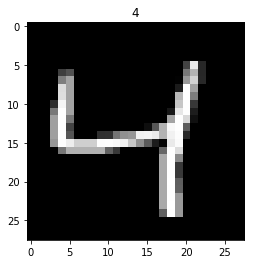

In [4]:
# Mnist digits dataset
train_data = MNIST(
    root='./data/mnist/',
    train=True,                                     # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = DataLoader(dataset=train_data, batch_size=note.params.batch_size, shuffle=True)


In [5]:
import src.network as net
import src.utils as my
from sys import stdout

def to_gpu(x):
    gpu = 0
    if note.params.gpu<-1:
        return x
    if note.params.gpu==-1:
        gpu = 0
    else:
        gpu = note.params.gpu
    return x.cuda(gpu)
def to_cpu(x):
    if note.params.gpu<-1:
        return x
    return x.cpu()

try:
    writer.close()
    my.reset_tensorboard(note.params.output)
except:
    pass
from tensorboardX import SummaryWriter
writer = SummaryWriter(note.params.output)

def objective(trial): 
    AE = net.AutoEncoder(note.params,logger,input_dim=1, gpu=note.params.gpu,trial=trial)

    optimizer = eval(note.params.optimizer.format('AE',note.params.learning_rate))
    epoch = 0
    global_step = 0
    AE.train()
    
    print('test params')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))    
    model_path = os.path.join(note.params.output,'model_Trial%02d_'%(trial.trial_id))
    
    for epoch in range(0,note.params.num_epochs):
        for batch_idx, (x,y) in enumerate(train_loader):
            x_true = to_gpu(x)
            x = to_gpu(2*x-1)
            y = to_gpu(y)
            optimizer.zero_grad()
            z,x_pred = AE.forward(x)
            # z = z.detach() # to use z for further calculation.        

            # calc reconstruction loss
            l = AE.calc_loss('reconstruction',global_step,x_pred,x_true, writer=writer)
            l.backward()


            optimizer.step()
            if batch_idx % 100 == 0:
                x_show = np.hstack([to_cpu(x_true[0]).detach(),to_cpu(x_pred[0]).detach()])
                writer.add_image('x_pred_epoch%03d'%epoch, x_show, global_step)

                trial.report(to_cpu(l.detach()), global_step)
                
                # Handle pruning based on the intermediate value.
                if trial.should_prune(epoch):
                    AE.remove(model_path,epoch-1)
                    raise optuna.structs.TrialPruned()

            loss_data = to_cpu(l.detach()).numpy()
            stdout.write(
                'Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\r'.
                format(epoch, note.params.num_epochs, batch_idx * len(x), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_data))        
            global_step += 1

                
            
        AE.save(model_path,epoch)
    AE.remove(model_path,epoch)
    AE.save(model_path)
    print(to_cpu(l.detach()).numpy())
    return to_cpu(l.detach()).numpy()

In [6]:
# reset tensorboard
# netのlayer対応拡張
# AE.calc_loss_all
study = optuna.create_study()#pruner=optuna.pruners.SuccessiveHalvingPruner())
study.optimize(objective,n_trials=5)

test params
    conv01: 3
    conv02: 3
    conv03: 13
    AE_depth: 4


/opt/pyenv/versions/3.6.5/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning:

nn.Upsample is deprecated. Use nn.functional.interpolate instead.



0.06535339h: 2/3 [44928/60000 (100%)]	Loss: 0.065353


[I 2019-01-24 19:16:08,035] Finished a trial resulted in value: 0.0653533935546875. Current best value is 0.0653533935546875 with parameters: {'conv01': 3, 'conv02': 3, 'conv03': 13, 'AE_depth': 4}.


test params
    conv01: 2
    conv02: 3
    conv03: 9
    AE_depth: 2
0.06900515h: 2/3 [44928/60000 (100%)]	Loss: 0.069005


[I 2019-01-24 19:16:42,688] Finished a trial resulted in value: 0.06900514662265778. Current best value is 0.0653533935546875 with parameters: {'conv01': 3, 'conv02': 3, 'conv03': 13, 'AE_depth': 4}.


test params
    conv01: 1
    conv02: 4
    conv03: 16
    AE_depth: 4
0.06414326h: 2/3 [44928/60000 (100%)]	Loss: 0.064143


[I 2019-01-24 19:17:16,502] Finished a trial resulted in value: 0.06414326280355453. Current best value is 0.06414326280355453 with parameters: {'conv01': 1, 'conv02': 4, 'conv03': 16, 'AE_depth': 4}.


test params
    conv01: 4
    conv02: 7
    conv03: 9
    AE_depth: 2
0.06670266h: 2/3 [44928/60000 (100%)]	Loss: 0.066703


[I 2019-01-24 19:17:57,574] Finished a trial resulted in value: 0.06670265644788742. Current best value is 0.06414326280355453 with parameters: {'conv01': 1, 'conv02': 4, 'conv03': 16, 'AE_depth': 4}.


test params
    conv01: 2
    conv02: 2
    conv03: 15
    AE_depth: 4
0.061998647: 2/3 [44928/60000 (100%)]	Loss: 0.061999


[I 2019-01-24 19:18:30,613] Finished a trial resulted in value: 0.0619986467063427. Current best value is 0.0619986467063427 with parameters: {'conv01': 2, 'conv02': 2, 'conv03': 15, 'AE_depth': 4}.


In [7]:
pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]

print('Study statistics: ')
print('  Number of finished trials: ', len(study.trials))
print('  Number of pruned trials: ', len(pruned_trials))
print('  Number of complete trials: ', len(complete_trials))

print('Best trial: %03d'%study.best_trial.trial_id)
trial = study.best_trial

print('  Value: ', trial.value)

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
from optuna.visualization import plot_intermediate_values

plot_intermediate_values(study)


Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial: 004
  Value:  0.0619986467063427
  Params: 
    conv01: 2
    conv02: 2
    conv03: 15
    AE_depth: 4


TypeError: dict expected at most 1 arguments, got 2